In [1]:
"""Imports"""

from astropy.io import fits, ascii
from astropy.table import Table
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy.wcs import WCS
from astropy import units as au
from astropy import stats
import scipy as sp
from scipy import ndimage
from spectral_cube import SpectralCube
from scimes import SpectralCloudstering

from astrodendro.analysis import PPStatistic
from astrodendro import Dendrogram, pp_catalog

import aplpy

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

/Users/ashleybarnes/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading and preping the data

In [39]:
"""Load data"""

datapath = '/Users/ashleybarnes/Dropbox/work/Smallprojects/galaxies/ngc1672'

# HST Ha data 
inputfile = '%s/hst_contsub/550m814w/ngc1672_halpha_final.fits' %datapath
hdu = fits.open(inputfile)[0]
# hdu_all = fits.open(inputfile)[0]

# HST cont data
inputfile = '%s/hst_contsub//550m814w/ngc1672_cont.fits' %datapath
hdu_cont = fits.open(inputfile)[0]

# MUSE Ha data
inputfile = '%s/data/muse/NGC1672-0.96asec_MAPS.fits' %datapath
hdu_muse = fits.open(inputfile)[1]

# MUSE nebula catalouge mask data
inputfile = '%s/data/muse/NGC1672_nebulae_mask_V2.fits' %datapath
hdu_nebcat = fits.open(inputfile)[0]

In [40]:
"""Cut out test region - using spectral cube because thats easy"""

def cropmap(hdu_, region):

    hdu_tmp = hdu_.copy() #Creating dummy file
    hdu_tmp.data = [hdu_tmp.data, hdu_tmp.data]

    hdu_tmp.header['CDELT3'] = 1
    hdu_tmp.header['CRPIX3'] = 1
    hdu_tmp.header['CRVAL3'] = 1
    hdu_tmp.header['CUNIT3'] = 'km/s'
    hdu_tmp.header['CTYPE3'] = 'VELO'

    cube = SpectralCube.read(hdu_tmp)
    cube = cube.subcube_from_ds9region(region)

    hdu_tmp = cube.hdu 
    hdu_tmp.data = hdu_tmp.data[0]
    del hdu_tmp.header['*3']
    hdu_tmp.header['WCSAXES'] = 2

    hdu_= hdu_tmp
    
    return(hdu_)

"""Define test region -- DS9 format"""
region = 'fk5; box(4:45:46.9964,-59:14:05.280,17.796",36.932",0)' 
""""""

hdu = cropmap(hdu, region)
hdu_muse = cropmap(hdu_muse, region)
hdu_nebcat = cropmap(hdu_nebcat, region)

## Save file
# hdu_tmp.writeto('./ngc1672_halpha_testregion.fits', overwrite=True)

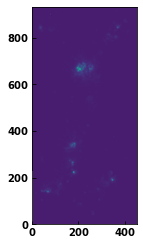

In [41]:
"""Quick check"""
plt.imshow(hdu.data, origin='lower')

In [42]:
"""Get Beam information and some simple stats"""

header = hdu.header
wcs = WCS(header)
data = hdu.data
data = np.squeeze(data)

# data_all = hdu_all.data #Whole map
# data_all = np.squeeze(data_all)

pixsize = np.array([-1*header['CDELT1'], header['CDELT2']]).mean() *au.degree
bmaj = 0.05 *au.arcsec
bmin = 0.05 *au.arcsec

# mask = hdu_cont.data<0
# std = stats.mad_std(data[mask], ignore_nan=True)
# std = stats.mad_std(data[data<0], ignore_nan=True)
# std = stats.mad_std(data_all[data_all<0], ignore_nan=True)
std = 3e-19 #Manual check of the map in DS9
print('STD: %4g' %std)

STD: 3e-19


# Running Dendrogram

see https://dendrograms.readthedocs.io/en/stable/

In [43]:
"""Provide dendrogram crtiteria"""

min_value = std*2 #Minimum value within structure
min_delta = std*5 #Minimum values between levels within structure (sort of)
min_npix  = 9 #Minimum number of pixel for strucutres

In [44]:
"""Running the dendrogram"""

dendro = Dendrogram.compute(data,
                min_delta=min_delta,
                min_value=min_value,
                min_npix=min_npix,
                wcs=wcs)

"""Provide some metadata for table output"""

metadata = {}
metadata['data_unit'] = au.Jy / au.beam #Dummy unit
metadata['spatial_scale'] =  pixsize.to('arcsec')
metadata['beam_major'] =  bmaj.to('arcsec')
metadata['beam_minor'] =  bmin.to('arcsec')
    
props = pp_catalog(dendro, metadata, verbose=False) #Get table
index_map = dendro.index_map #Get index map
index_map_hdu = fits.PrimaryHDU(index_map, header)
index_map_hdu.data = np.array(index_map_hdu.data, dtype=float)

INFO: Auto-setting vmin to -5.745e-19 [aplpy.core]
INFO: Auto-setting vmax to  1.515e-17 [aplpy.core]
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.220e+02 [aplpy.core]
INFO: Auto-setting vmin to -5.417e-19 [aplpy.core]
INFO: Auto-setting vmax to  1.446e-17 [aplpy.core]
INFO: Auto-setting vmin to -1.822e+01 [aplpy.core]
INFO: Auto-setting vmax to -1.543e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.822e+01 [aplpy.core]
INFO: Auto-setting vmax to -1.543e+01 [aplpy.core]
INFO: Auto-setting vmin to  6.700e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.562e+03 [aplpy.core]


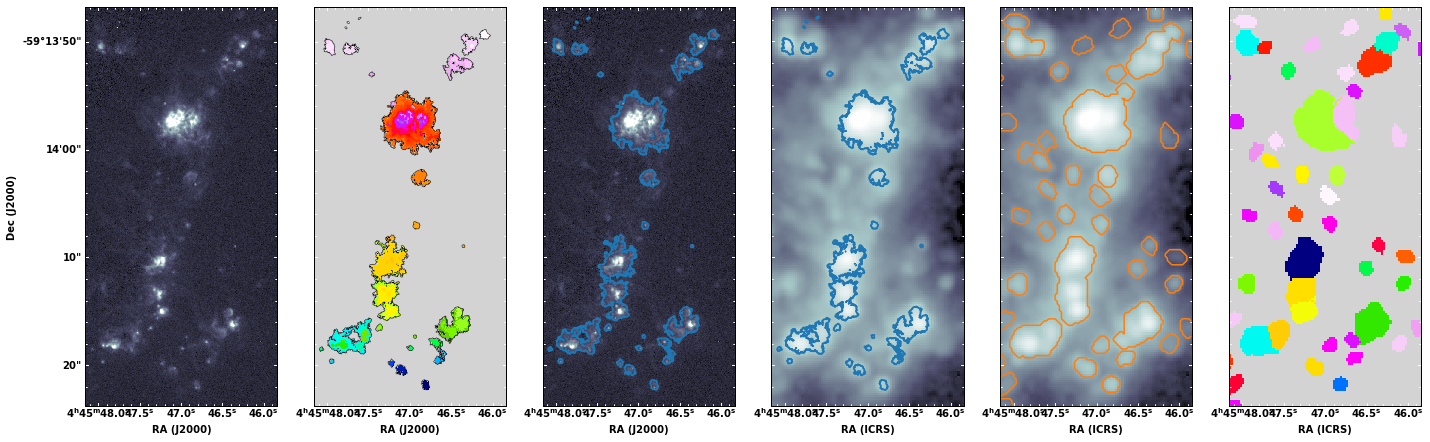

In [47]:
"""Plotting the index map for checking"""

index_map_hdu.data[index_map_hdu.data==-1] = np.nan
hdu_nebcat.data[hdu_nebcat.data==-1] = np.nan

fig = plt.figure(figsize=(20,10))
ax1 = aplpy.FITSFigure(hdu, figure=fig, subplot=(1,6,1))
ax2 = aplpy.FITSFigure(index_map_hdu, figure=fig, subplot=(1,6,2))
ax3 = aplpy.FITSFigure(hdu, figure=fig, subplot=(1,6,3))
ax4 = aplpy.FITSFigure(hdu_muse, figure=fig, subplot=(1,6,4))
ax5 = aplpy.FITSFigure(hdu_muse, figure=fig, subplot=(1,6,5))
ax6 = aplpy.FITSFigure(hdu_nebcat, figure=fig, subplot=(1,6,6))

ax1.show_colorscale(cmap='bone', stretch='sqrt')
ax2.show_colorscale(cmap='gist_ncar', stretch='sqrt')
ax3.show_colorscale(cmap='bone', stretch='sqrt')
ax4.show_colorscale(cmap='bone', stretch='sqrt')
ax5.show_colorscale(cmap='bone', stretch='sqrt')
ax6.show_colorscale(cmap='gist_ncar', stretch='sqrt')

ax2.set_nan_color('lightgrey')
ax6.set_nan_color('lightgrey')

ax2.tick_labels.hide_y()
ax3.tick_labels.hide_y()
ax4.tick_labels.hide_y()
ax5.tick_labels.hide_y()
ax6.tick_labels.hide_y()

ax2.axis_labels.hide_y()
ax3.axis_labels.hide_y()
ax4.axis_labels.hide_y()
ax5.axis_labels.hide_y()
ax6.axis_labels.hide_y()

index_map_hdu.data = np.nan_to_num(index_map_hdu.data, nan=-1) 
hdu_nebcat.data = np.nan_to_num(hdu_nebcat.data, nan=-1) 

ax2.show_contour(index_map_hdu, levels=[-1], colors='black', linestyles='-', linewidths=0.5)
ax3.show_contour(index_map_hdu, levels=[-1], colors='C0', linestyles='-')
ax4.show_contour(index_map_hdu, levels=[-1], colors='C0', linestyles='-')
ax4.show_contour(index_map_hdu, levels=[-1], colors='C0', linestyles='-')
ax5.show_contour(hdu_nebcat, levels=[-1], colors='C1', linestyles='-')
# ax6.show_contour(hdu_nebcat, levels=[-1], colors='black', linestyles='-', linewidths=0.5)

fig.tight_layout()
fig.savefig('./figures/dendroindexmap_region1.pdf', bbox_inches='tight', dpi=300)

- Dendrogram appears to be doing a good job of including all the emission that I would say if a "HII region". 
- Potentially not splitting the emission up enough? Some of the distinct regions are merged? 
- Moving forward - but probable worth returning to in future
- Picking up a lot of features from MUSE - interesting not all... 
- Features that are broken up in MUSE - aren't in the HST dendrogram, which is not what we want... 

# Running scimes

see https://scimes.readthedocs.io/en/latest/index.html

SAVE_ALL_LEAVES triggered: isolated leaves and unclustered leaves will be retained
- Creating affinity matrices
- Start spectral clustering
-- Rescaling flux matrix
-- Estimated scaling parameter: 0.000000
-- Guessed number of clusters = 12
-- Number of k-means iteration: 1
-- Best cluster number found through SILHOUETTE (1.000000)= 8
-- Final cluster number (after cleaning) 8
-- Final clustering configuration silhoutte -0.037068
SAVE_ISOL_LEAVES triggered. Isolated leaves added.
-- Total cluster number 26
SAVE_CLUST_LEAVES triggered. Unclustered leaves added.
-- Total cluster number 26
Generate assignment cubes...


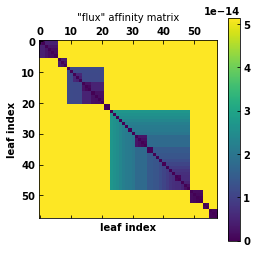

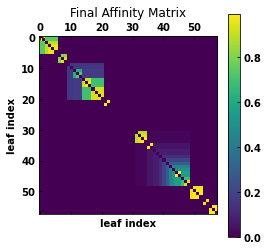

In [48]:
"""Simple run of the scimes algorithm"""

dclust = SpectralCloudstering(dendro, #provide output of dendro 
                              props, #provide props table
                              header, #fits header
                              criteria = ['flux'], #only using 2D here, so have to use the flux (?) 
                              save_all_leaves=True) #keeps all the small scale structures

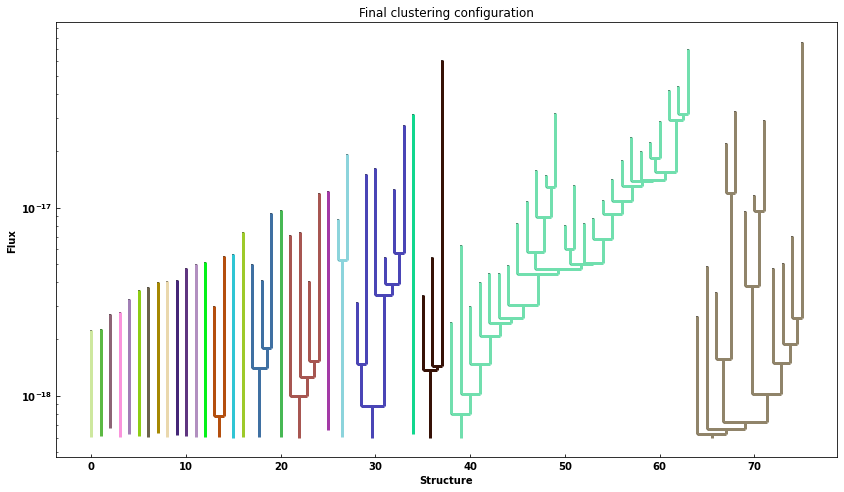

In [49]:
"""Show the structure"""
dclust.showdendro()

INFO: Auto-setting vmin to -5.218e-19 [aplpy.core]
INFO: Auto-setting vmax to  1.197e-17 [aplpy.core]


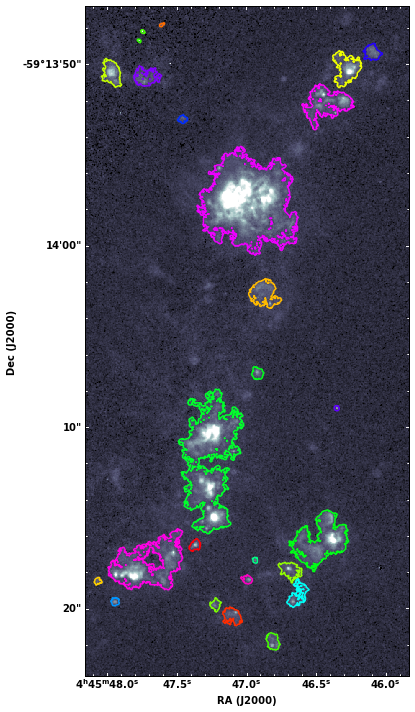

In [50]:
"""Plotting the index maps for the clusters_asgn"""
"""Note that this keeps the small scale stuff in"""

fig = plt.figure(figsize=(10,10))
ax = aplpy.FITSFigure(hdu, figure=fig)
ax.show_colorscale(cmap='bone', stretch='sqrt')

idx = list(np.unique(dclust.clusters_asgn.data))
idx.remove(-1)
color = cm.rainbow(np.linspace(0, 1, len(idx)))

for i, idx_ in enumerate(idx): 
    contours = dclust.clusters_asgn.data.copy()
    contours[contours!=idx_] = -1
    contours_hdu = fits.PrimaryHDU(contours, header)
    ax.show_contour(contours_hdu, colors=matplotlib.colors.rgb2hex(cm.gist_rainbow(np.random.random())), levels=[idx_], linestyles='-')

fig.tight_layout()
fig.savefig('./figures/scimesindexmap_region1.pdf', bbox_inches='tight', dpi=300)

- Results are looking generally pretty good - including all? of the emission I would call a HII region 
- Some of the structures are a little large and include multiple smaller HII regions
- Question: Where do we draw the line of what is a single region? 

In [51]:
"""Saving the output"""
"""Not implemneted yet - need finalising"""
# dclust.clusters_asgn.writeto('dclust.clusters_asgn.fits', overwrite=True)

'Not implemneted yet - need finalising'